## Import e Utility Functions

In [18]:
import tensorflow as tf
from tensorflow import keras
import os
import random
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout, Conv2D, AveragePooling2D, MaxPooling2D
from keras import regularizers, optimizers
from keras.callbacks import EarlyStopping
from keras.initializers import HeNormal
from tensorflow.keras.utils import plot_model
import pydot
from keras.preprocessing.image import ImageDataGenerator
import warnings
warnings.filterwarnings("ignore") # ignora un FutureWarning di Pandas
tf.random.set_seed(42)

In [2]:
def add_result_to_csv(model_name, accuracy, file_name='results.csv'):
    # Check if the file exists
    file_exists = os.path.isfile(file_name)
    
    # If the file exists, read it into a DataFrame
    if file_exists:
        df = pd.read_csv(file_name)
    else:
        # If the file does not exist, create an empty DataFrame
        df = pd.DataFrame(columns=['Model', 'Accuracy'])
    
    # Create a new DataFrame with the new result
    new_data = pd.DataFrame([[model_name, accuracy]], columns=['Model', 'Accuracy'])
    
    # Concatenate the existing DataFrame with the new data
    df = pd.concat([df, new_data], ignore_index=True)
    
    # Save the updated DataFrame to the CSV file
    df.to_csv(file_name, index=False)

In [3]:
def read_accuracy_from_csv(model_name, csv_file_name='results.csv'):
    try:
        # Read the CSV file into a pandas DataFrame
        df = pd.read_csv(csv_file_name)

        # Find the accuracy corresponding to the model name
        accuracy = df.loc[df['Model'] == model_name, 'Accuracy'].values[0]

        return accuracy
    
    except FileNotFoundError:
        print(f"File '{csv_file_name}' not found.")
        return None
    except IndexError:
        print(f"Model '{model_name}' not found in file '{csv_file_name}'.")
        return None

In [4]:
# Controlla le GPU disponibili
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    print(f"Numero di GPU disponibili: {len(gpus)}")
    for gpu in gpus:
        print(f"Nome GPU: {gpu.name}")
else:
    print("Nessuna GPU disponibile")

Numero di GPU disponibili: 1
Nome GPU: /physical_device:GPU:0


## Import e Pre-processamento Dataset

In [5]:
x = np.load(r"C:\Users\filip\Desktop\Filippo\Uni\Magistrale\ML\pneumonia_images.npy")
y = np.load(r"C:\Users\filip\Desktop\Filippo\Uni\Magistrale\ML\pneumonia_labels.npy")

#creazione dei vari dataset
seed = 1999
#separazione train e test set
train_images, test_images = train_test_split(x, test_size=0.1, random_state=seed)
train_labels, test_labels = train_test_split(y, test_size=0.1, random_state=seed)

print("Numero di immagini totale = ", len(x))
print("Numero di immagini nel testing set = ", len(test_images))

Numero di immagini totale =  5232
Numero di immagini nel testing set =  524


In [6]:
# creazione validation set e train set con split 80/20 a favore del training set
x_valid_images = train_images[3765:]/255. # normalizzazione
x_valid_labels = train_labels[3765:]
x_train_images = train_images[:3765]/255. # normalizzazione
x_train_labels = train_labels[:3765]

#normalizzazione test set
test_images = test_images/255.

print("Numero di immagini nel training set = ", len(x_train_images))
print("Numero di immagini nel validation set = ", len(x_valid_images))

Numero di immagini nel training set =  3765
Numero di immagini nel validation set =  943


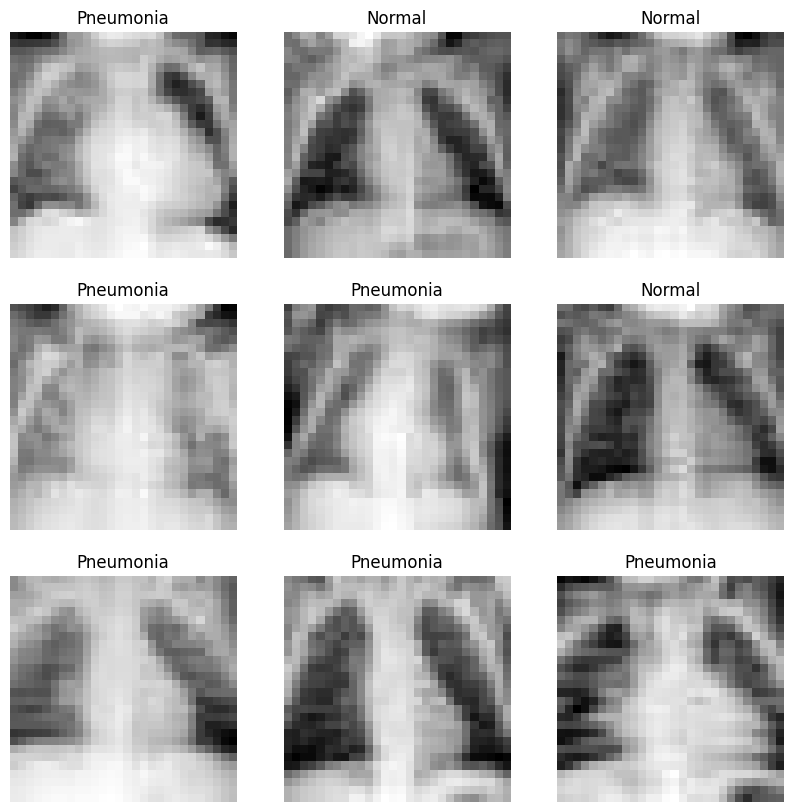

In [14]:
plt.figure(figsize=(10, 10))
for i in range(0, 9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(x_train_images[i], cmap='gray')
    label = 'Normal' if  x_train_labels[i] == 0 else 'Pneumonia'
    plt.title(label)
    plt.axis("off")

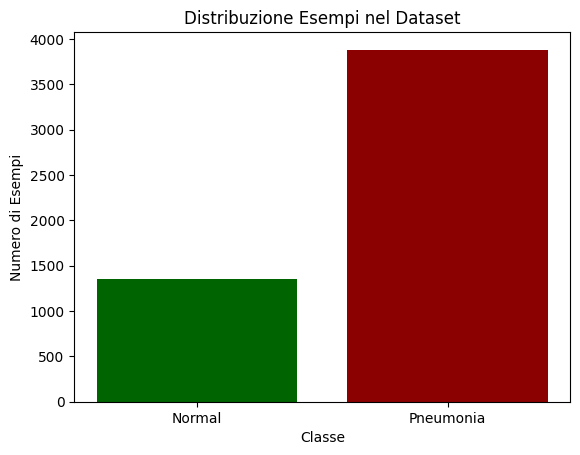

In [17]:
# Conta le occorrenze di ciascuna etichetta
unique, counts = np.unique(y, return_counts=True)
labels_counts = dict(zip(unique, counts))

# Crea il grafico a colonne
fig, ax = plt.subplots()
ax.bar(labels_counts.keys(), labels_counts.values(), color=['darkgreen', 'darkred'])

# Imposta i titoli e le etichette
ax.set_xlabel('Classe')
ax.set_ylabel('Numero di Esempi')
ax.set_title('Distribuzione Esempi nel Dataset')
ax.set_xticks([0, 1])
ax.set_xticklabels(['Normal', 'Pneumonia'])

# Mostra il grafico
plt.show()


## Random Forest

In [33]:
x_train_flat = x_train_images.reshape(x_train_images.shape[0], -1)
x_valid_flat = x_valid_images.reshape(x_valid_images.shape[0], -1)
test_flat = test_images.reshape(test_images.shape[0], -1)

# Creazione del modello di Random Forest
rf = RandomForestClassifier(random_state=42) # seed per rendere l'esecuzione ripetibile

# Definizione della griglia degli iperparametri
param_grid = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'n_estimators': [200, 300, 500],
    'max_depth': [None, 30],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [2, 4],
    'bootstrap': [True, False]
}

# Creazione della grid search
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=3)

# Addestramento della grid search
grid_search.fit(x_train_flat, x_train_labels.ravel()) # circa 10 minuti per la grid search

# Migliori iperparametri trovati
print("Best parameters found: ", grid_search.best_params_)

# Valutazione del modello sul validation set
best_rf = grid_search.best_estimator_
valid_predictions = best_rf.predict(x_valid_flat)
accuracy = accuracy_score(x_valid_labels.ravel(), valid_predictions)
print("Validation set accuracy: ", accuracy)

# Valutazione finale sul test set
test_predictions = best_rf.predict(test_flat)
test_accuracy_random_forest = accuracy_score(test_labels.ravel(), test_predictions)
print("Test set accuracy: ", test_accuracy_random_forest)

Fitting 3 folds for each of 144 candidates, totalling 432 fits
Best parameters found:  {'bootstrap': False, 'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
Validation set accuracy:  0.95864262990456
Test set accuracy:  0.9599236641221374


In [34]:
add_result_to_csv('Random Forest', test_accuracy_random_forest) # aggiunta entry per RF nel .csv

In [35]:
report_test = classification_report(test_labels.ravel(), test_predictions)
print(report_test)

              precision    recall  f1-score   support

           0       0.92      0.92      0.92       132
           1       0.97      0.97      0.97       392

    accuracy                           0.96       524
   macro avg       0.95      0.95      0.95       524
weighted avg       0.96      0.96      0.96       524



## Regressione Logistica

In [40]:
# Creazione del modello di Logistic Regression
# Utilizzando Pipeline per standardizzare i dati e applicare la regressione logistica
pipe = Pipeline([
    ('scaler', StandardScaler()),  # Standardizzazione dei dati
    ('logreg', LogisticRegression(random_state=42, max_iter=100))
])

# Definizione della griglia degli iperparametri per la regressione logistica
param_grid_logreg = [
    {'logreg__C': [0.01, 0.1, 1, 10, 100], # termine per la regolarizzazione. Più è piccolo più è forte 
     'logreg__solver': ['liblinear'],
     'logreg__penalty': ['l1', 'l2']},
    {'logreg__C': [0.01, 0.1, 1, 10, 100],
     'logreg__solver': ['saga'],
     'logreg__penalty': ['l1', 'l2', 'elasticnet'],
     'logreg__l1_ratio': [0.5]},  # l1_ratio è richiesto per elasticnet
    {'logreg__C': [0.01, 0.1, 1, 10, 100],
     'logreg__solver': ['newton-cg', 'lbfgs', 'sag', 'newton-cholesky'],
     'logreg__penalty': ['l2']}
]
# Creazione della grid search
grid_search_logreg = GridSearchCV(estimator=pipe, param_grid=param_grid_logreg, cv=3, n_jobs=-1, verbose=3)

In [41]:
# Addestramento della grid search
grid_search_logreg.fit(x_train_flat, x_train_labels.ravel())

# Migliori iperparametri trovati
print("Best parameters found for Logistic Regression: ", grid_search_logreg.best_params_)

# Valutazione del modello sul validation set
best_logreg = grid_search_logreg.best_estimator_
valid_predictions_logreg = best_logreg.predict(x_valid_flat)
accuracy_logreg = accuracy_score(x_valid_labels.ravel(), valid_predictions_logreg)
print("Validation set accuracy for Logistic Regression: ", accuracy_logreg)

# Valutazione finale sul test set
test_predictions_logreg = best_logreg.predict(test_flat)
test_accuracy_logreg = accuracy_score(test_labels.ravel(), test_predictions_logreg)
print("Test set accuracy for Logistic Regression: ", test_accuracy_logreg)

Fitting 3 folds for each of 45 candidates, totalling 135 fits
Best parameters found for Logistic Regression:  {'logreg__C': 0.1, 'logreg__penalty': 'l2', 'logreg__solver': 'sag'}
Validation set accuracy for Logistic Regression:  0.9618239660657476
Test set accuracy for Logistic Regression:  0.9675572519083969


In [42]:
add_result_to_csv('Logistic Regression', test_accuracy_logreg) # aggiunta entry per RF nel .csv

In [10]:
report_test_logreg = classification_report(test_labels.ravel(), test_predictions_logreg)
print(report_test_logreg)

              precision    recall  f1-score   support

           0       0.91      0.89      0.90       132
           1       0.96      0.97      0.97       392

    accuracy                           0.95       524
   macro avg       0.93      0.93      0.93       524
weighted avg       0.95      0.95      0.95       524



## CNN

In [31]:
seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

x_reshaped_train = x_train_images.reshape(-1,28,28,1)
x_reshaped_valid = x_valid_images.reshape(-1,28,28,1)
test_reshaped = test_images.reshape(-1,28,28,1)

init = keras.initializers.HeNormal(seed=42) # best for ReLu
con_init = keras.initializers.GlorotUniform(seed=42) # default ma con seed fissato per ripetibilità 

CNN_lenet = Sequential([
    Conv2D(10, kernel_size=(5, 5), activation='relu',padding='same',input_shape=(28,28,1), kernel_initializer=con_init),
    AveragePooling2D(pool_size=(2, 2),strides=2),
    Conv2D(20, kernel_size=(5, 5), activation='relu', kernel_initializer=con_init),
    AveragePooling2D(pool_size=(2, 2),strides=2),
    Flatten(),
    Dense(256, activation='relu', kernel_initializer=init),
    Dense(128, activation='relu', kernel_initializer=init),
    Dense(1, activation='sigmoid')
])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


CNN_lenet.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history_cnn_lenet = CNN_lenet.fit(x_reshaped_train, x_train_labels, epochs=300, validation_data=(x_reshaped_valid, x_valid_labels), callbacks=[early_stopping])


Epoch 1/300
118/118 [==============================] - 2s 9ms/step - loss: 0.3157 - accuracy: 0.8598 - val_loss: 0.2087 - val_accuracy: 0.9088
Epoch 2/300
118/118 [==============================] - 1s 6ms/step - loss: 0.1893 - accuracy: 0.9227 - val_loss: 0.1783 - val_accuracy: 0.9247
Epoch 3/300
118/118 [==============================] - 1s 7ms/step - loss: 0.1620 - accuracy: 0.9331 - val_loss: 0.1294 - val_accuracy: 0.9533
Epoch 4/300
118/118 [==============================] - 1s 6ms/step - loss: 0.1519 - accuracy: 0.9378 - val_loss: 0.1269 - val_accuracy: 0.9470
Epoch 5/300
118/118 [==============================] - 1s 8ms/step - loss: 0.1511 - accuracy: 0.9413 - val_loss: 0.1568 - val_accuracy: 0.9343
Epoch 6/300
118/118 [==============================] - 1s 6ms/step - loss: 0.1406 - accuracy: 0.9450 - val_loss: 0.2031 - val_accuracy: 0.9141
Epoch 7/300
118/118 [==============================] - 1s 7ms/step - loss: 0.1228 - accuracy: 0.9556 - val_loss: 0.1010 - val_accuracy: 0.9586

In [32]:
#test set
cnn_lenet_loss, cnn_lenet_accuracy = CNN_lenet.evaluate(test_reshaped, test_labels)
print('CNN_lenet_accuracy over test set = ', cnn_lenet_accuracy)

17/17 [==============================] - 0s 5ms/step - loss: 0.0889 - accuracy: 0.9714
CNN_lenet_accuracy over test set =  0.9713740348815918


In [33]:
add_result_to_csv('CNN LeNet', cnn_lenet_accuracy)
CNN_lenet.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 28, 28, 10)        260       
_________________________________________________________________
average_pooling2d_10 (Averag (None, 14, 14, 10)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 10, 10, 20)        5020      
_________________________________________________________________
average_pooling2d_11 (Averag (None, 5, 5, 20)          0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 500)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 256)               128256    
_________________________________________________________________
dense_16 (Dense)             (None, 128)              

## CNN + Dropout

In [42]:
x_reshaped_train = x_train_images.reshape(-1,28,28,1)
x_reshaped_valid = x_valid_images.reshape(-1,28,28,1)
test_reshaped = test_images.reshape(-1,28,28,1)

init = keras.initializers.HeNormal(seed=42)

CNN_lenet_opt = Sequential([
    Conv2D(10, kernel_size=(5, 5), activation='relu',padding='same',input_shape=(28,28,1)),
    AveragePooling2D(pool_size=(2, 2),strides=2),        
    Dropout(0.35),
    Conv2D(20, kernel_size=(5, 5), activation='relu'),
    AveragePooling2D(pool_size=(2, 2),strides=2),
    Dropout(0.35),
    Flatten(),
    Dense(256, activation='relu', kernel_initializer=init),
    Dropout(0.7),
    Dense(128, activation='relu', kernel_initializer=init),
    Dropout(0.7),
    Dense(1, activation='sigmoid')
])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


CNN_lenet_opt.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history_cnn_lenet = CNN_lenet_opt.fit(x_reshaped_train, x_train_labels, epochs=300, validation_data=(x_reshaped_valid, x_valid_labels), callbacks=[early_stopping])

Epoch 1/300
118/118 [==============================] - 2s 12ms/step - loss: 0.5798 - accuracy: 0.7315 - val_loss: 0.5498 - val_accuracy: 0.7487
Epoch 2/300
118/118 [==============================] - 1s 11ms/step - loss: 0.4325 - accuracy: 0.7811 - val_loss: 0.2514 - val_accuracy: 0.9109
Epoch 3/300
118/118 [==============================] - 2s 13ms/step - loss: 0.2829 - accuracy: 0.8786 - val_loss: 0.2021 - val_accuracy: 0.9183
Epoch 4/300
118/118 [==============================] - 1s 10ms/step - loss: 0.2454 - accuracy: 0.9017 - val_loss: 0.1597 - val_accuracy: 0.9427
Epoch 5/300
118/118 [==============================] - 1s 10ms/step - loss: 0.2151 - accuracy: 0.9155 - val_loss: 0.1938 - val_accuracy: 0.9268
Epoch 6/300
118/118 [==============================] - 1s 10ms/step - loss: 0.2079 - accuracy: 0.9201 - val_loss: 0.1453 - val_accuracy: 0.9427
Epoch 7/300
118/118 [==============================] - 1s 8ms/step - loss: 0.1946 - accuracy: 0.9262 - val_loss: 0.1291 - val_accuracy: 

In [43]:
#test set
CNN_lenet_opt_loss, CNN_lenet_opt_accuracy = CNN_lenet_opt.evaluate(test_reshaped, test_labels)
print('CNN_lenet_opt_accuracy over test set = ', CNN_lenet_opt_accuracy)

17/17 [==============================] - 0s 5ms/step - loss: 0.0629 - accuracy: 0.9809
CNN_lenet_opt_accuracy over test set =  0.9809160232543945


In [44]:
add_result_to_csv('CNN LeNet Dropout', CNN_lenet_opt_accuracy)
CNN_lenet.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 28, 28, 10)        260       
_________________________________________________________________
average_pooling2d_10 (Averag (None, 14, 14, 10)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 10, 10, 20)        5020      
_________________________________________________________________
average_pooling2d_11 (Averag (None, 5, 5, 20)          0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 500)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 256)               128256    
_________________________________________________________________
dense_16 (Dense)             (None, 128)              

### CNN + Dropout + Batch Normalization

In [7]:
# Reshape dei dati di input
x_reshaped_train = x_train_images.reshape(-1, 28, 28, 1)
x_reshaped_valid = x_valid_images.reshape(-1, 28, 28, 1)
test_reshaped = test_images.reshape(-1, 28, 28, 1)

# Inizializzazione dei pesi
init = HeNormal(seed=42)

# Costruzione della rete con batch normalization
CNN_lenet_opt_bn = Sequential([
    Conv2D(10, kernel_size=(5, 5), padding='same', input_shape=(28, 28, 1)),
    BatchNormalization(),
    Activation('relu'),
    AveragePooling2D(pool_size=(2, 2), strides=2),
    Dropout(0.3),

    Conv2D(20, kernel_size=(5, 5)),
    BatchNormalization(),
    Activation('relu'),
    AveragePooling2D(pool_size=(2, 2), strides=2),
    Dropout(0.3),

    Flatten(),

    Dense(256, kernel_initializer=init),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.7),

    Dense(128, kernel_initializer=init),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.7),

    Dense(1, activation='sigmoid')
])

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Compilazione del modello
CNN_lenet_opt_bn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Addestramento del modello
history_cnn_lenet_bn = CNN_lenet_opt_bn.fit(x_reshaped_train, x_train_labels, epochs=300, validation_data=(x_reshaped_valid, x_valid_labels), callbacks=[early_stopping])


Epoch 1/300
32/32 [==============================] - 2s 20ms/step - loss: 0.8006 - accuracy: 0.6100 - val_loss: 0.5761 - val_accuracy: 0.7449
Epoch 2/300
32/32 [==============================] - 0s 12ms/step - loss: 0.5111 - accuracy: 0.7710 - val_loss: 0.5228 - val_accuracy: 0.7449
Epoch 3/300
32/32 [==============================] - 0s 13ms/step - loss: 0.3680 - accuracy: 0.8500 - val_loss: 0.5207 - val_accuracy: 0.7449
Epoch 4/300
32/32 [==============================] - 0s 15ms/step - loss: 0.3091 - accuracy: 0.8670 - val_loss: 0.5205 - val_accuracy: 0.7449
Epoch 5/300
32/32 [==============================] - 0s 14ms/step - loss: 0.2810 - accuracy: 0.8890 - val_loss: 0.4868 - val_accuracy: 0.7449
Epoch 6/300
32/32 [==============================] - 0s 16ms/step - loss: 0.2809 - accuracy: 0.8920 - val_loss: 0.4893 - val_accuracy: 0.7449
Epoch 7/300
32/32 [==============================] - 0s 13ms/step - loss: 0.2562 - accuracy: 0.9020 - val_loss: 0.6266 - val_accuracy: 0.7449
Epoch 

In [8]:
#test set
CNN_lenet_opt_bn.evaluate(test_reshaped, test_labels)

17/17 [==============================] - 0s 3ms/step - loss: 0.1054 - accuracy: 0.9656


[0.10544075071811676, 0.9656488299369812]

Mentre il dropout sembra aver migliorato leggermente l'accuracy, la Batch Normalization non sembra avere lo stesso effetto, avendo una accuracy sul testing set leggermente più bassa rispetto al modello precedente.

## CNN con blocco Inception

In [19]:
# Funzione per creare un blocco Inception
def single_inception_block(x, filters):
    layers = tf.keras.layers
    # Branch 1: 1x1 Convolution
    branch1 = layers.Conv2D(filters, (1, 1), padding='same', activation='relu')(x)
    
    # Branch 2: 1x1 Convolution followed by 3x3 Convolution
    branch2 = layers.Conv2D(filters, (1, 1), padding='same', activation='relu')(x)
    branch2 = layers.Conv2D(filters, (3, 3), padding='same', activation='relu')(branch2)
    
    # Branch 3: 1x1 Convolution followed by 5x5 Convolution
    branch3 = layers.Conv2D(filters, (1, 1), padding='same', activation='relu')(x)
    branch3 = layers.Conv2D(filters, (5, 5), padding='same', activation='relu')(branch3)
    
    # Branch 4: 3x3 MaxPooling followed by 1x1 Convolution
    branch4 = layers.MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    branch4 = layers.Conv2D(filters, (1, 1), padding='same', activation='relu')(branch4)
    
    # Concatenate all branches
    output = layers.concatenate([branch1, branch2, branch3, branch4], axis=-1)
    return output

# Costruzione del modello
def create_single_inception_cnn(input_shape):
    inputs = tf.keras.Input(shape=input_shape)
    layers = tf.keras.layers

    
    # blocco Inception
    x = single_inception_block(inputs, 128)
    
    # Aggiunta di un Global Average Pooling per ridurre la dimensionalità
    x = layers.GlobalAveragePooling2D()(x)
    
    # Aggiunta di livelli densi per la classificazione
    init = keras.initializers.HeNormal(seed=42)

    x = layers.Dense(256, activation='relu', kernel_initializer=init)(x)
    x = layers.Dense(128, activation='relu', kernel_initializer=init)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    
    model = tf.keras.models.Model(inputs, outputs)
    return model

# Creazione del modello con input shape (28, 28, 1)
input_shape = (28, 28, 1)
CNN_single_inception = create_single_inception_cnn(input_shape)

# Compilazione del modello
CNN_single_inception.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Riassunto del modello
#model.summary()

In [20]:
# Creazione del callback EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Addestramento del modello
history_single_inception = CNN_single_inception.fit(x_train_images, x_train_labels, epochs=300,
                    verbose=1,
                    validation_data=(x_valid_images, x_valid_labels),
                    callbacks=[early_stopping])



Epoch 1/300
32/32 [==============================] - 3s 45ms/step - loss: 0.5861 - accuracy: 0.7290 - val_loss: 0.5622 - val_accuracy: 0.7449
Epoch 2/300
32/32 [==============================] - 1s 31ms/step - loss: 0.5841 - accuracy: 0.7290 - val_loss: 0.5697 - val_accuracy: 0.7449
Epoch 3/300
32/32 [==============================] - 1s 30ms/step - loss: 0.5880 - accuracy: 0.7290 - val_loss: 0.5725 - val_accuracy: 0.7449
Epoch 4/300
32/32 [==============================] - 1s 29ms/step - loss: 0.5868 - accuracy: 0.7290 - val_loss: 0.5598 - val_accuracy: 0.7449
Epoch 5/300
32/32 [==============================] - 1s 31ms/step - loss: 0.5775 - accuracy: 0.7290 - val_loss: 0.5575 - val_accuracy: 0.7449
Epoch 6/300
32/32 [==============================] - 1s 29ms/step - loss: 0.5770 - accuracy: 0.7290 - val_loss: 0.5599 - val_accuracy: 0.7449
Epoch 7/300
32/32 [==============================] - 1s 30ms/step - loss: 0.5714 - accuracy: 0.7290 - val_loss: 0.5510 - val_accuracy: 0.7449
Epoch 

In [22]:
CNN_single_inception.evaluate(test_images, test_labels)
CNN_single_inception.summary()

17/17 [==============================] - 0s 10ms/step - loss: 0.1405 - accuracy: 0.9504
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 28, 28, 128)  256         input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_23 (Conv2D)              (None, 28, 28, 128)  256         input_4[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_3 (MaxPooling2D)  (None, 28, 28, 1)    0           input_4[0][0]                    
____

L'idea è quella di costruire una CNN che richiami quella sviluppata da Google (GoogLeNet) andando a sfruttare il blocco transformer. Si opera questa scelta perché una rete del genere ha mostrato ottime prestazioni in passato, e per non dover cercare di ottimizzare il tipo di Pooling e la dimensione dei Kernel, andandone a sfruttare di diverse dimensioni all'interno del blocco Inception.

In [38]:
# Funzione per creare un blocco Inception
def inception_module(x, filters):
    layers = tf.keras.layers
    # Branch 1: 1x1 Convolution
    branch1 = layers.Conv2D(filters, (1, 1), padding='same', activation='relu')(x)
    
    # Branch 2: 1x1 Convolution followed by 3x3 Convolution
    branch2 = layers.Conv2D(filters, (1, 1), padding='same', activation='relu')(x)
    branch2 = layers.Conv2D(filters, (3, 3), padding='same', activation='relu')(branch2)
    
    # Branch 3: 1x1 Convolution followed by 5x5 Convolution
    branch3 = layers.Conv2D(filters, (1, 1), padding='same', activation='relu')(x)
    branch3 = layers.Conv2D(filters, (5, 5), padding='same', activation='relu')(branch3)
    
    # Branch 4: 3x3 MaxPooling followed by 1x1 Convolution
    branch4 = layers.MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    branch4 = layers.Conv2D(filters, (1, 1), padding='same', activation='relu')(branch4)
    
    # Concatenate all branches
    output = layers.concatenate([branch1, branch2, branch3, branch4], axis=-1)
    return output

# Costruzione del modello
def create_inception_cnn(input_shape):
    inputs = tf.keras.Input(shape=input_shape)
    layers = tf.keras.layers

    # Primo blocco Inception
    x = inception_module(inputs, 32)

    # Secondo blocco Inception
    x = inception_module(x, 64)

    # Terzo blocco Inception
    x = inception_module(x, 128)

    # Aggiunta di un Global Average Pooling per ridurre la dimensionalità
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.4)(x)
    
    # Aggiunta di un livello denso per la classificazione
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.4)(x)
    
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.4)(x)
    
    x = layers.Dense(512, activation='relu')(x)

    outputs = layers.Dense(1, activation='sigmoid')(x)
    
    model = tf.keras.models.Model(inputs, outputs)
    return model

# Creazione del modello con input shape (28, 28, 1) per immagini in scala di grigi
input_shape = (28, 28, 1)
cnn_inception_extended = create_inception_cnn(input_shape)

# Compilazione del modello
cnn_inception_extended.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Riassunto del modello
#cnn_inception_extended.summary()

In [39]:
# Creazione del callback EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Addestramento del modello
history = cnn_inception_extended.fit(x_train_images, x_train_labels, epochs=300,
                    verbose=1,
                    validation_data=(x_valid_images, x_valid_labels),
                    callbacks=[early_stopping])


Epoch 1/300
32/32 [==============================] - 4s 68ms/step - loss: 0.6088 - accuracy: 0.7190 - val_loss: 0.5645 - val_accuracy: 0.7449
Epoch 2/300
32/32 [==============================] - 2s 59ms/step - loss: 0.5958 - accuracy: 0.7290 - val_loss: 0.5606 - val_accuracy: 0.7449
Epoch 3/300
32/32 [==============================] - 2s 59ms/step - loss: 0.5884 - accuracy: 0.7290 - val_loss: 0.5878 - val_accuracy: 0.7449
Epoch 4/300
32/32 [==============================] - 2s 59ms/step - loss: 0.5421 - accuracy: 0.7290 - val_loss: 0.6724 - val_accuracy: 0.7505
Epoch 5/300
32/32 [==============================] - 2s 60ms/step - loss: 0.5649 - accuracy: 0.7030 - val_loss: 0.4065 - val_accuracy: 0.7449
Epoch 6/300
32/32 [==============================] - 2s 60ms/step - loss: 0.6022 - accuracy: 0.6980 - val_loss: 0.5879 - val_accuracy: 0.7449
Epoch 7/300
32/32 [==============================] - 2s 59ms/step - loss: 0.6128 - accuracy: 0.7290 - val_loss: 0.6056 - val_accuracy: 0.7449
Epoch 

In [56]:
cnn_inception_extended.evaluate(test_images, test_labels)

17/17 [==============================] - 0s 10ms/step - loss: 0.1561 - accuracy: 0.9447


[0.15605896711349487, 0.944656491279602]

Best: 0.9695

In [ ]:
# Visualizzazione della struttura del modello
plot_model(cnn_inception_extended, to_file='model_structure.png', show_shapes=True, show_layer_names=True)

# Mostra l'immagine della struttura del modello
img = plt.imread('model_structure.png')
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis('off')
plt.show()

## Data Augmentation sul miglior modello

In [51]:
# Reshape dei dati di input
x_reshaped_train = x_train_images.reshape(-1, 28, 28, 1)
x_reshaped_valid = x_valid_images.reshape(-1, 28, 28, 1)
test_reshaped = test_images.reshape(-1, 28, 28, 1)

# Inizializzazione dei pesi
init = HeNormal(seed=42)

# Definizione della CNN
input_shape = (28, 28, 1)
cnn_inception_extended_da = create_inception_cnn(input_shape)

# Compilazione del modello
cnn_inception_extended_da.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
# Configurazione della Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=0.05,  # no rotazione
    width_shift_range=0.05,  # Spostamento casuale orizzontale del 10% della larghezza
    height_shift_range=0.05,  # Spostamento casuale verticale del 10% dell'altezza
    zoom_range=0.05,  # Zoom casuale del 10%
    horizontal_flip=False,  # Ribaltamento casuale orizzontale
    vertical_flip=False  # Senza ribaltamento casuale verticale
)

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


# Addestramento del modello con Data Augmentation
history_cnn_inception_extended_da = cnn_inception_extended_da.fit(
    datagen.flow(x_reshaped_train, x_train_labels, batch_size=32),
    steps_per_epoch=len(x_reshaped_train) // 32,
    epochs=300,
    validation_data=(x_reshaped_valid, x_valid_labels),
    callbacks=[early_stopping]
)

Epoch 1/300
31/31 [==============================] - 4s 69ms/step - loss: 0.5975 - accuracy: 0.7293 - val_loss: 0.6042 - val_accuracy: 0.7449
Epoch 2/300
31/31 [==============================] - 2s 59ms/step - loss: 0.5889 - accuracy: 0.7293 - val_loss: 0.6072 - val_accuracy: 0.7449
Epoch 3/300
31/31 [==============================] - 2s 60ms/step - loss: 0.5953 - accuracy: 0.7314 - val_loss: 0.5698 - val_accuracy: 0.7449
Epoch 4/300
31/31 [==============================] - 2s 61ms/step - loss: 0.5894 - accuracy: 0.7324 - val_loss: 0.5726 - val_accuracy: 0.7449
Epoch 5/300
31/31 [==============================] - 2s 60ms/step - loss: 0.5844 - accuracy: 0.7293 - val_loss: 0.5452 - val_accuracy: 0.7449
Epoch 6/300
31/31 [==============================] - 2s 60ms/step - loss: 0.5446 - accuracy: 0.7314 - val_loss: 0.4651 - val_accuracy: 0.7754
Epoch 7/300
31/31 [==============================] - 2s 61ms/step - loss: 0.5184 - accuracy: 0.7490 - val_loss: 0.4240 - val_accuracy: 0.8031
Epoch 

In [52]:
# Valutazione del modello sui dati di test
test_loss, test_accuracy = cnn_inception_extended_da.evaluate(test_reshaped, test_labels)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

17/17 [==============================] - 0s 11ms/step - loss: 0.1086 - accuracy: 0.9599
Test Loss: 0.10857484489679337
Test Accuracy: 0.9599236845970154
